<a href="https://colab.research.google.com/github/nikorose87/DJS-GA/blob/master/PCA_n_kPCA_classification_solved.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification and Regression plus feature extraction using Gait data

## Prof. Nikolay Prieto 
*Universidad de San Buenaventura - Sede Bogotá*

We are going to apply Artificial Intelligence techniques to classify either the speed of the subject and the age group according to the data given from Horst's article [doi](https://data.mendeley.com/datasets/svx74xcrjr/3).



Let us explain the procedure:



In [17]:
!wget https://www.dropbox.com/s/bqodz4qn7zhi3cz/Horst_mean.csv
!wget https://www.dropbox.com/s/2bfc8vne4rx7o9d/Gait_subject_info.csv
!wget https://www.dropbox.com/s/8g3kimgzy7j4o5x/Horst_Nature_paper.csv

--2021-04-20 23:39:34--  https://www.dropbox.com/s/bqodz4qn7zhi3cz/Horst_mean.csv
Resolving www.dropbox.com (www.dropbox.com)... 162.125.6.18, 2620:100:6019:18::a27d:412
Connecting to www.dropbox.com (www.dropbox.com)|162.125.6.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/bqodz4qn7zhi3cz/Horst_mean.csv [following]
--2021-04-20 23:39:34--  https://www.dropbox.com/s/raw/bqodz4qn7zhi3cz/Horst_mean.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucea067f967fe16a69687f9c9e75.dl.dropboxusercontent.com/cd/0/inline/BNA8H_nC3xoADWaXYvOIpXHHe3Kw_MGDrbXSlln5bvLOa51PVoOigsM4_yDxvE09c__MUMDPTixEQ8C5q9ZjuafvkSjFgRhOkImbQBun1eLVBYnNdSCV9MmiJPJqSwk2ycbfPjqtlOR-OgPvNak2nN0W/file# [following]
--2021-04-20 23:39:34--  https://ucea067f967fe16a69687f9c9e75.dl.dropboxusercontent.com/cd/0/inline/BNA8H_nC3xoADWaXYvOIpXHHe3Kw_MGDrbXSlln5bvLOa51PVoOigsM4_yDxvE09c__MUMDPTixEQ8C5q9Zj

In [18]:
#Checking if the file is already there
import sys
import os
#print(sys.path)
!pwd
!ls

/content
Gait_subject_info.csv	 Horst_mean.csv.1	   Horst_Nature_paper.csv.2
Gait_subject_info.csv.1  Horst_mean.csv.2	   Horst_Nature_paper.csv.3
Gait_subject_info.csv.2  Horst_mean.csv.3	   sample_data
Gait_subject_info.csv.3  Horst_Nature_paper.csv
Horst_mean.csv		 Horst_Nature_paper.csv.1


# Some concepts about Human Gait

## How the planes in human motion are named

![human planes](https://drive.google.com/uc?id=1icMDhWCw_1s4FKYPgSEJYIUX7_Wwo3x1)

The anatomical position and the three different planes with their respective fundamental directions. Taken from [Whittle2007].

## Terminology in movements
![movements in gait](https://www.dropbox.com/s/7rcfoyscrrdxl3e/movements.png?dl=1)

Movements from the hip and knee joint. Taken from [Whittle2007].

## Terminology only for ankle foot
![foot movements](https://www.dropbox.com/s/42k3nxuwtxibvm2/foot_movements.png?dl=1)

Movements of the ankle, toes hindfoot and forefoot. Taken from [Whittle2007].

## How the data was processed 

We have used the Opensim API to process real gait data in order to give you the joint angles and joint moments for each subject.

Also, we have taken the average of more than 15 gait trials in which they have taken to measure their unique dynamics. Remind that the raw data was taken from [Horst2019].

![Opensim](https://raw.githubusercontent.com/opensim-org/opensim-core/master/doc/images/opensim_running.gif)

With Opensim we have obtained all the kinematic and kinetic data for each trial with the following procedure:

![Kinematics](https://simtk-confluence.stanford.edu:8443/download/attachments/29164184/worddav18beee95e9328969b6f5ee05a6c736f0.png?version=1&modificationDate=1530846003979&api=v2)

Let us load the libraries needed to process this notebook





In [19]:
import warnings
import numpy as np
import pandas as pd
from bokeh.layouts import row, column
from bokeh.palettes import Spectral6, Set3
from bokeh.plotting import figure, show, gridplot
from bokeh.models import ColumnDataSource
from bokeh.models.glyphs import Text
from bokeh.io import reset_output, output_notebook
from scipy.integrate import simps
import scipy.optimize as optimization
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from pathlib import PurePath
import os
warnings.filterwarnings('ignore')
output_notebook()
##Cleaning and selecting the data
reset_output()

Horst_mean = pd.read_csv('Horst_mean.csv', header=[0,1], index_col=[0,1])

output_label = pd.read_csv('Gait_subject_info.csv', sep=";",
                          decimal=',')
## Building the subtables

Let us check how the data is behaving:

In [20]:
Horst_mean.sample(10)

Subject                                     S01  ...         S57
                                           -1sd  ...        +1sd
Feature              Gait cycle [%]              ...            
lumbar_rotation      0.1313           -7.004898  ...    1.634182
pelvis_rotation      0.4646           -0.636305  ...  -11.445763
ankle_angle_r_moment 0.3030          -71.033252  ...  -22.269332
arm_rot_l            0.4646           15.018797  ...    3.893941
ground_force_2_v_1   0.9697          125.818619  ...  109.527844
pelvis_ty            0.6869            0.953505  ...    0.957996
ground_force_1_v_1   0.8586            0.411154  ...    0.055059
lumbar_extension     0.5354          -30.267299  ...  -27.003210
pelvis_list          0.2929            0.252729  ...   -4.566842
ground_force_2_v_2   0.7677          587.803086  ...  500.951808

[10 rows x 171 columns]

In [21]:
idx = pd.IndexSlice
Horst_mean.loc[idx[:,0.0000], idx['S01':'S05','mean']]

,Subject,S01,S02,S03,S04,S05
,,mean,mean,mean,mean,mean
Feature,Gait cycle [%],,,,,
ankle_angle_l,0.0,-0.473996,11.831290,8.646964,12.509623,4.269443
ankle_angle_l_moment,0.0,1.114588,0.511005,-0.113427,-0.032257,-0.107927
ankle_angle_r,0.0,-12.545011,-1.818371,-7.496694,-4.678172,-8.516900
ankle_angle_r_moment,0.0,-1.805458,-2.774155,-3.309013,-3.500285,-1.371002
arm_add_l,0.0,-27.958237,-23.271284,-31.093385,-26.362080,-28.790745
...,...,...,...,...,...,...
subtalar_angle_r_moment,0.0,0.040546,0.503221,0.784451,1.342203,-0.050722
wrist_dev_l_moment,0.0,-0.077003,-0.007965,0.028832,0.003765,0.017769


In [22]:
%matplotlib inline
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import math
from itertools import combinations

#Setting plot parameters
plt.rcParams.update({'font.size': 22})
# Cleaning the plots
plt.cla()
plt.clf()
plt.close()
sd=False
def lcm(a, b):
    return abs(a*b) // math.gcd(a, b)


def get_mult_num(integer):
  """
  From https://stackoverflow.com/questions/54556363/finding-two-integers-that-multiply-to-20-can-i-make-this-code-more-pythonic
  """
  given_comb = [1,1,2,2,3,3,4,4,5,5,6,6,7,7,8,8,9,9,10,10,11,11,12,12]
  return [(i, j) for i, j in list(combinations(given_comb,2)) if i * j == integer]
  
def subpl(integer, a=9, dif=3):
  """
  Function to generate the best combination among a number of plots
  It does not work, use_get_mult_num instead
  """
  a_init = a
  b_init = b = a - dif 
  try:
    while lcm(a,b) != integer and a+b >=0:
      print(a,b)
      a -= 1
      b -= 1
  except (ValueError, ZeroDivisionError) as e:
    print('Determining the suitable division could not be done, trying bypairs')
    dif += 1
    a,b = subpl(integer, a=a_init, dif=dif)
  return a,b


In [23]:
def gait_plot(df_, label=None, index=None, sd=False, title=False):
  # Cleaning the plots
  plt.cla()
  plt.clf()
  plt.close()
  
  # Getting the first index in rows
  indexes= df_.index.get_level_values(0).unique()
  if index is not None:
      indexes = indexes[index]
  #Gait cycle
  x = df_.index.get_level_values(1).unique()
  #nrows, ncols = subpl(len(lab))
  nrows, ncols = get_mult_num(len(indexes))[-1]
  fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(nrows*ncols*2, ncols*nrows), sharex=True)
  # "ravel" flattens the numpy array without making a copy
  for j, ax in enumerate(axs.ravel()):
    for i in label:
      mean = df_[i,'mean'][indexes[j]].values
      sd_min = df_[i,'-1sd'][indexes[j]].values
      sd_max = df_[i,'+1sd'][indexes[j]].values
      ax.plot(x, mean, '-')
      if sd:
        ax.fill_between(x, sd_min, sd_max, alpha=0.2)
      ax.set_xlabel('Gait cycle [%]')
      ax.set_ylabel(indexes[j]+' [deg]')
  ax.legend(label, loc='center left', bbox_to_anchor=(1, 0.5))
  if title:  plt.suptitle(title)
  plt.show()
  # ax.plot(x, y, 'o', color='tab:brown')
  return

In [24]:
labels = Horst_mean.columns.get_level_values(0).unique()
len(Horst_mean.index.get_level_values(0).unique())

88

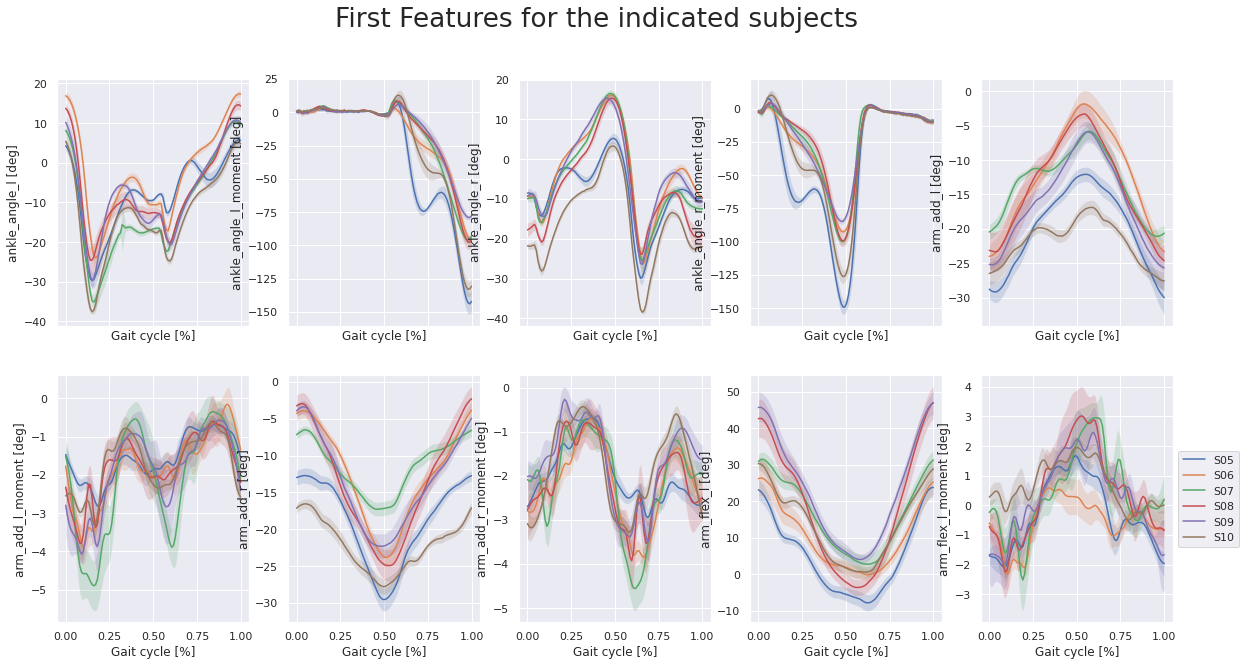

In [25]:
gait_plot(Horst_mean, labels[4:10], index=np.r_[:10], sd=True, title='First Features for the indicated subjects')

In [26]:
output_label

,subject_id [number],"gender [1 = ""female"" / 0 =""male""]",age [years],body mass [kg],body size [m]
0,S01,0,29,68.90,1.75
1,S02,1,21,64.90,1.81
2,S03,0,21,80.80,1.84
3,S04,0,23,82.70,1.82
4,S05,1,26,54.90,1.63
5,S06,0,21,77.30,1.79
6,S07,0,24,94.20,1.91
7,S08,0,23,69.50,1.88
8,S09,0,26,72.00,1.84
9,S10,1,20,52.30,1.58


In [27]:
#Make sure your dataset has the same shape, at least in terms of index
Horst_mean_T = Horst_mean.loc[:,idx[:, 'mean']].T #transpose to make the index the values to reduce features
Horst_mean_T.shape[0] == output_label.shape[0]
Horst_mean_T.shape

(57, 8800)

In [28]:
from sklearn.decomposition import PCA

var = []
for comp in range(1,10):
  pc = PCA(n_components = comp)
  Horst_red = pc.fit_transform(Horst_mean_T)
  var.append(sum(pc.explained_variance_ratio_))


As we have explained in our lectures, with the Principal Components we can obtain the same variance but we fewer features. As we see below, it can be established that since the 3th component we can do either classification or regression. 

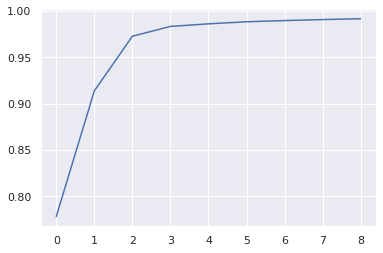

In [29]:
fig, ax = plt.subplots(1,1)
ax.plot(range(len(var)), var)
plt.show()

From this, and according to the output label, we can try the prediction of: Age, gender, Height or, body mass. An example of a regression prediction for body mass, using a pipeline is shown below:

## How to use the PCA to classify according to the data

We are going to base on the work done by **Eskofier et al** [Eskofier2012] which abstract is:


> *The classification of gait patterns has great potential as a diagnostic tool, for example, for the diagnosis of injury or to identify at-risk gait in the elderly. The purpose of the paper is to present a method for classifying group differences in gait pattern by using the complete spatial and temporal information of the segment motion quantified by the markers. The classification rates that are obtained are compared with previous studies using conventional classification features. For our analysis, 37 three-dimensional marker trajectories were collected from each of our 24 young and 24 elderly female subjects while they were walking on a treadmill. Principal component analysis was carried out on these trajectories to retain the spatial and temporal information in the markers. Using a Support Vector Machine with a linear kernel, a classification rate of 95.8% was obtained. This classification approach also allowed visualisation of the contribution of individual markers to group differentiation in position and time. The approach made no specific assumptions and did not require prior knowledge of specific time points in the gait cycle. It is therefore directly applicable for group classification tasks in any study involving marker measurements.*


# Your Task


1.   Be familiar with the Anthropometric concepts implied in the dataset.
2.   Modify the output labels in groups: 
      * Age will be categorized in three groups: 20-24, 24-27, >27
      * Body mass will have three categories divide in equitative portions to categorized in lighter, medium, heavier.
      * Height will have three categories: short, medium, tall.
3.   Apply the PCA with 2 components, after that plot the four output labels: gender, age, mass and height. Is there any correlation on any chart?, Is lineary or non-lineary separable? 
4.    Perform the three classification pipelines to predict future values. What is the accuracy on each? What are the units of those metrics? 
5.    Make your conclusions: is it helpful to apply PCA?, is really accurate the classification pipelines implemented? and whatever insight should be mentioned.






In [30]:
def age_cat(x):
  if x <= 24:
    out = 'Youngest'
  elif x > 24 and x <=27:
    out = 'Medium age'
  elif x > 27:
    out = 'Older'
  return out

def mass_cat(x):
  if x <= 65:
    out = 'Lighters'
  elif x > 65 and x <=80:
    out = 'Medium mass'
  elif x > 80:
    out = 'Heaviers'
  return out

def height_cat(x):
  if x <= 1.70:
    out = 'Shorter'
  elif x > 1.70 and x <=1.85:
    out = 'Medium height'
  elif x > 1.85:
    out = 'Tallers'
  return out

output_label_cat = output_label.copy()
output_label_cat["age [years]"] = output_label_cat["age [years]"].apply(age_cat)
output_label_cat["body mass [kg]"] = output_label_cat["body mass [kg]"].apply(mass_cat)
output_label_cat["body size [m]"] = output_label_cat["body size [m]"].apply(height_cat)
#Replacing the gender label
output_label_cat = output_label_cat.rename(columns={'gender [1 = "female" / 0 ="male"]': 'Gender [M-F]'})
output_label_cat['Gender [M-F]'] = output_label_cat['Gender [M-F]'].replace([0,1],['Male', 'Female'])
output_label_cat

,subject_id [number],Gender [M-F],age [years],body mass [kg],body size [m]
0,S01,Male,Older,Medium mass,Medium age
1,S02,Female,Youngest,Lighters,Medium age
2,S03,Male,Youngest,Heviers,Medium age
3,S04,Male,Youngest,Heviers,Medium age
4,S05,Female,Medium age,Lighters,Shorter
5,S06,Male,Youngest,Medium mass,Medium age
6,S07,Male,Youngest,Heviers,Older
7,S08,Male,Youngest,Medium mass,Older
8,S09,Male,Medium age,Medium mass,Medium age
9,S10,Female,Youngest,Lighters,Shorter


In [36]:
# Setting the PCAs for the dataset
pc_2 = PCA(n_components = 2)
Horst_red_2 = pc_2.fit_transform(Horst_mean_T)
tot_variance = pc_2.explained_variance_ratio_
print('The remaining variance after PCA is {}'.format(1 - sum(pc_2.explained_variance_ratio_)))

The remaining variance after PCA is 0.0862296574059137


In [50]:
import seaborn as sns

concat_PCA = pd.concat([pd.DataFrame(Horst_red_2), output_label_cat], axis=1)
concat_PCA = concat_PCA.rename(columns={0:'PCA 1', 1:'PCA 2'})
concat_PCA = concat_PCA.drop([16, 26])
concat_PCA.head()

,PCA 1,PCA 2,subject_id [number],Gender [M-F],age [years],body mass [kg],body size [m]
0,-813.055163,-299.820120,S01,Male,Older,Medium mass,Medium age
1,-801.467916,-354.553991,S02,Female,Youngest,Lighters,Medium age
2,-836.956364,-301.413761,S03,Male,Youngest,Heviers,Medium age
3,-856.264859,-388.720506,S04,Male,Youngest,Heviers,Medium age
4,-781.098661,-219.752580,S05,Female,Medium age,Lighters,Shorter


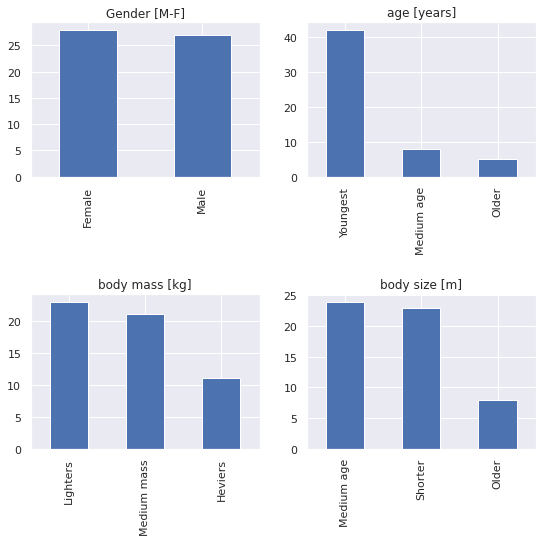

In [60]:
fig, ax = plt.subplots(2,2, figsize=(8,8))
axs = np.ravel(ax)
dict_label = {}
for num, cols in enumerate(concat_PCA.columns[-4:]):
  dict_label.update({cols: concat_PCA[cols].unique()})
  concat_PCA[cols].value_counts().plot(kind='bar', ax = axs[num])
  axs[num].set_title(cols)

plt.tight_layout()

In [61]:
dict_label

{'Gender [M-F]': array(['Male', 'Female'], dtype=object),
 'age [years]': array(['Older', 'Youngest', 'Medium age'], dtype=object),
 'body mass [kg]': array(['Medium mass', 'Lighters', 'Heviers'], dtype=object),
 'body size [m]': array(['Medium age', 'Shorter', 'Older'], dtype=object)}

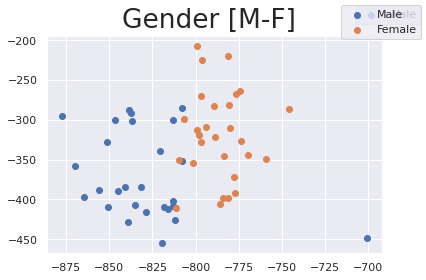

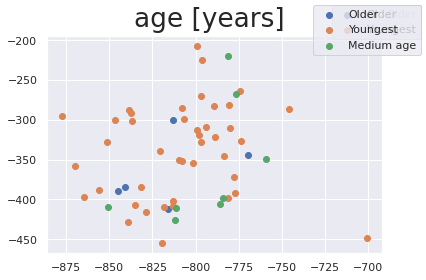

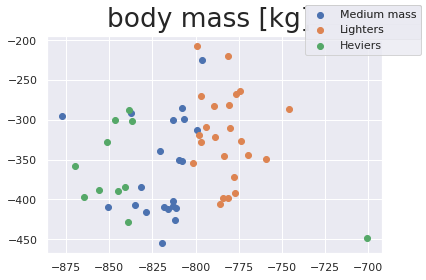

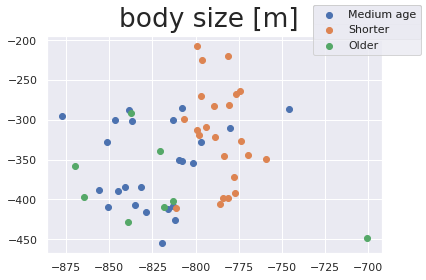

In [80]:
#fig, ax = plt.subplots(2,2)
#axs = np.ravel(ax)
cats= []
colors = ['r','g','b']
for num, (key, item) in enumerate(dict_label.items()):
  fig, ax = plt.subplots()
  for value in item:
    #print(key, value)
    cat = concat_PCA[concat_PCA[key] == value]
    ax = plt.scatter(x = cat['PCA 1'], y = cat['PCA 2'], label=value)
    fig.legend(item)
    fig.suptitle(key)
    #axs[num].set_title(cols)
#ax = plt.scatter(x = female['PCA 1'], y = female['PCA 2'], c='b')
plt.show()



[1] Horst, F., Lapuschkin, S., Samek, W., Müller, K. R., & Schöllhorn, W. I. (2019). Explaining the unique nature of individual gait patterns with deep learning. Scientific Reports, 9(1), 1–13. https://doi.org/10.1038/s41598-019-38748-8

[2] J. Figueiredo, C.P. Santos, J.C. Moreno, Automatic recognition of gait patterns in human motor disorders using machine learning: A review, Med. Eng. Phys. 53 (2018) 1–12. https://doi.org/10.1016/j.medengphy.2017.12.006.

[3] B.M. Eskofier, P. Federolf, P.F. Kugler, B.M. Nigg, Marker-based classification of young-elderly gait pattern differences via direct PCA feature extraction and SVMs, Comput. Methods Biomech. Biomed. Engin. 16 (2013) 435–442. https://doi.org/10.1080/10255842.2011.624515.

[4] M.W. Whittle, Gait Analysis an Introduction, 4th ed., Elsevier, 2007.


In [30]:
X_train, X_test, y_train, y_test = train_test_split(concat_PCA.iloc[:,:2], concat_PCA['body mass [kg]'], 
                                                    random_state=0, 
                                                    test_size= 0.4)

classifiers = [ ("SVM_lineal", SVC(kernel='linear')),
                ('Random Forest', RandomForestClassifier(bootstrap=True, 
                min_samples_split=2)]

param_grid = [{'C': [0.1, 0.5, 1, 5, 10, 50, 100]},
              {'C': [0.1, 1, 3], 'gamma': [0.1, 0.5]},
              {'C': [0.1, 0.5, 1, 5, 10, 50, 100], 'gamma': [0.1, 0.5, 1, 3, 6, 10]},
              {'C': [0.1, 0.5, 1, 5, 10, 50, 100]},
              {'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'], 
                             'leaf_size':range(5,61,5)},
              {'max_depth':range(1,50), 'min_samples_split':range(2,10)},
              {'n_estimators':[2, 20, 50, 100, 200, 250], #RF hyperparameters
              'max_depth':[None, 5, 8, 10],
              'min_samples_leaf':np.int64(np.linspace(1,20,7))},
              {'hidden_layer_sizes': np.int64(np.linspace(3,700,5)),
               'alpha': [0.0001, 0.01, 0.1, 0.5, 1.0],
               'learning_rate': ['constant', 'invscaling', 'adaptive']}]